# MIT License

Copyright 2020 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

This code is derived from the Case Study in Chapter 7, see https://github.com/DrDub/artfeateng

# Chapter 7: Case Study on Timestamped Data

In this chapter I will describe the creation of the extended version of WikiCities dataset with historical data. I will also present a country population prediction task to exemplify traditional time series algorithms.


## WikiCities: Historical

Used the following historical versions of DBpedia:

<table>
<tr><th>Version</th><th>Year</th><th>Code</th></tr>
<tr><td>3.6</td><td>2010</td><td>dbpedia10</td></tr>
<tr><td>3.7</td><td>2011</td><td>dbpedia11</td></tr>
<tr><td>3.8</td><td>2012</td><td>dbpedia12</td></tr>
<tr><td>3.9</td><td>2013</td><td>dbpedia13</td></tr>
<tr><td>2014</td><td>2014</td><td>dbpedia14</td></tr>
<tr><td>2015-04</td><td>2015</td><td>dbpedia15</td></tr>
</table>

Using scripts outside of this notebook, I have extracted the relevant triples from the dumps for all years into files CODE_cities1000_base.ttl (e.g., dbpedia12_cities1000_base.ttl). Because due to changes in the script (going from or "Phoenix%2C_Arizona" to "Phoenix,_Arizona") and in the source Wikipedia (going from "Utrecht" to "Utrecht_%28city%29"), the entity designators change from year to year, I have tried to standardize them using the provided GeoNames link for each year. In the historical versions the GeoNames data was limited and as many as half the cities are missing. This might also be due to lower coverage in the source Wikipedia in the earlier years. All in all, this represents the type of challenges of dealing with historical data in production systems.

From these files, I extracted the conservative feature set into CODE_dev_conservative.tsv, also outside the notebooks. This produced files CODE_dev_conservative.tsv. Again, due to changes in the ontology many columns (sometimes up to 50% of the columns) are empty. Interestingly, this number changes from year to year (not necessarily starting low and increasing). Therefore, it enables the specific type of temporal imputation enabled by timestamped data.

Let us start doing some EDA and see how this data set behaves.

## EDA: Exploratory Data Analysis

The first thing to take a look is how the total number of relations behaves year after year (Cell #1).

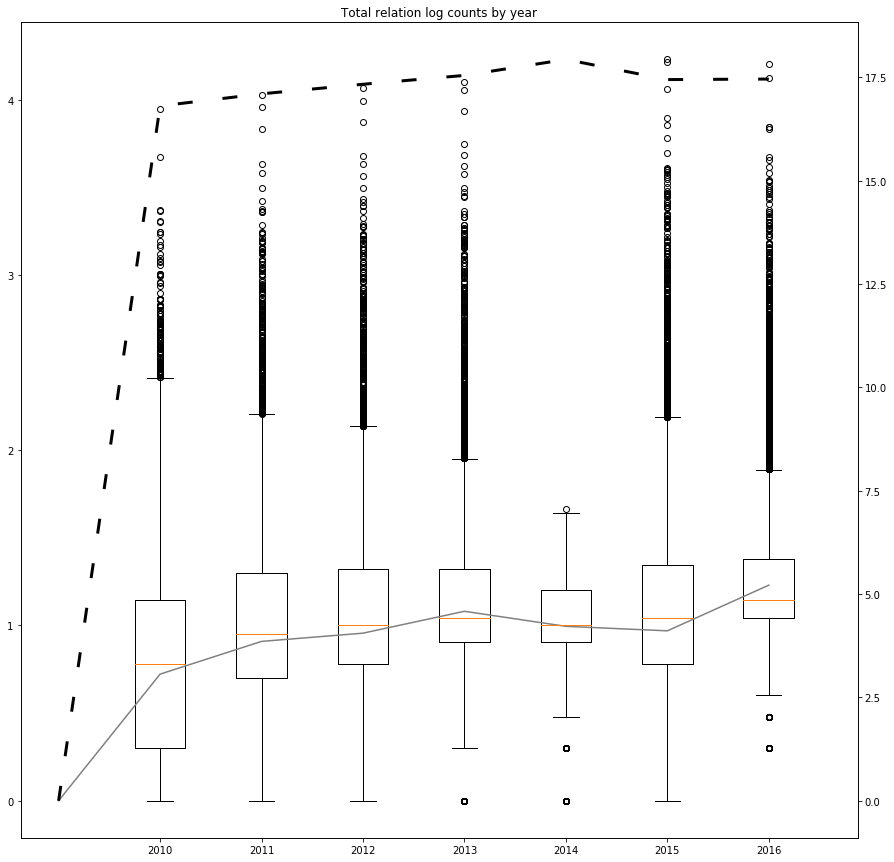

In [1]:
# CELL 1
import math
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display

DO_EDA = False

if not DO_EDA:
    display(Image(filename=os.path.join("..", "media", "cell1.png")))
else:
    # if you want to re-do the EDA, download http://artoffeatureengineering.com/notebooks/chapter7data.tar.bz2
    # and decompress it in the same folder as this notebook
    dbpedia_rels = [
        1, # padding
        19969604, # 2010
        26770236, # 2011
        33742028, # 2012
        41804713, # 2013
        61481509, # 2014
        37791134, # 2015
        38285149 # 2016
    ]

    city_col = 0
    rel_col = 1
    to_plot = list()
    means = list()
    city_to_data = None
    deleted_cities = set()
    for version in range(7):
        datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
        if version == 6:
            datafile = "ch6_cell32_dev_feat_conservative.tsv"
        city_relcounts = dict()
        with open(datafile) as f:
            first = True
            for line in f:
                fields = line.split("\t")
                if first:
                    first = False
                    if fields[city_col] != 'name':
                        raise Exception("Expected 'name', got " + fields[city_col])
                    if fields[rel_col] != 'rel#count':
                        raise Exception("Expected 'rel#count', got " + fields[rel_col])
                else:
                    city_relcounts[fields[city_col]] = float(fields[rel_col])
        if city_to_data is None:
            city_to_data = dict()
            for city, rel in city_relcounts.items():
                city_to_data[city] = [ rel ]
        else:
            to_delete = list()
            for city, l in city_to_data.items():
                if city in city_relcounts:
                    l.append(city_relcounts[city])
                else:
                    deleted_cities.add(city)
                    to_delete.append(city)
            for city in to_delete:
                del city_to_data[city]
    print("Plotting on {:,}".format(len(city_to_data)))
    cities = sorted(list(city_to_data.keys()))
    for version in range(7):
        relcounts = np.array([ city_to_data[city][version] for city in cities])
        to_plot.append(relcounts)
        means.append(np.mean(relcounts))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title('Total relation log counts by year')
    ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
    means.insert(0,0)
    ax.plot(range(8), means, 'b-', color='gray')
    ax2 = ax.twinx()
    ax2.plot(list(map(math.log,dbpedia_rels)), linestyle=(0,(5,10)), color='black', linewidth=3.0)
    plt.savefig("ch7_cell1_boxplot.pdf", bbox_inches='tight', dpi=300)
    plt

Interestingly, the average number of relations has not increased  as much as the average increase of DBpedia.

Let us see the behaviour of this number as related to the last year (Cell #2).

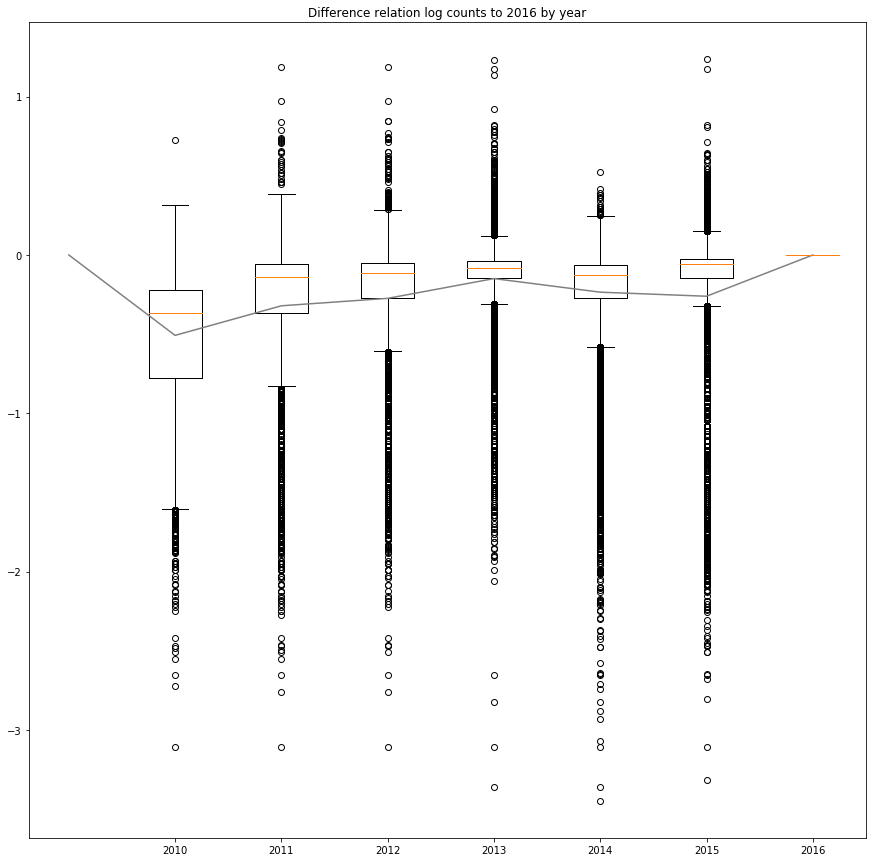

In [2]:
# CELL 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not DO_EDA:
    display(Image(filename=os.path.join("..", "media", "cell2.png")))
else:
    city_col = 0
    rel_col = 1
    to_plot = list()
    means = list()
    city_to_data = None
    deleted_cities = set()
    for version in range(7):
        datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
        if version == 6:
            datafile = "ch6_cell32_dev_feat_conservative.tsv"
        city_relcounts = dict()
        with open(datafile) as f:
            first = True
            for line in f:
                fields = line.split("\t")
                if first:
                    first = False
                    if fields[city_col] != 'name':
                        raise Exception("Expected 'name', got " + fields[city_col])
                    if fields[rel_col] != 'rel#count':
                        raise Exception("Expected 'rel#count', got " + fields[rel_col])
                else:
                    city_relcounts[fields[city_col]] = float(fields[rel_col])
        if city_to_data is None:
            city_to_data = dict()
            for city, rel in city_relcounts.items():
                city_to_data[city] = [ rel ]
        else:
            to_delete = list()
            for city, l in city_to_data.items():
                if city in city_relcounts:
                    l.append(city_relcounts[city])
                else:
                    deleted_cities.add(city)
                    to_delete.append(city)
            for city in to_delete:
                del city_to_data[city]
    print("Plotting on {:,}".format(len(city_to_data)))
    cities = sorted(list(city_to_data.keys()))
    for version in range(7):
        relcounts = np.array([ city_to_data[city][version] - city_to_data[city][-1] for city in cities ])
        to_plot.append(relcounts)
        means.append(np.mean(relcounts))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title('Difference relation log counts to 2016 by year')
    ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
    means.insert(0,0)
    ax.plot(range(8), means, 'b-', color='gray')
    plt.savefig("ch7_cell2_boxplot.pdf", bbox_inches='tight', dpi=300)
    plt

Let us now take a look at the number of different features to the current year (Cell #3).

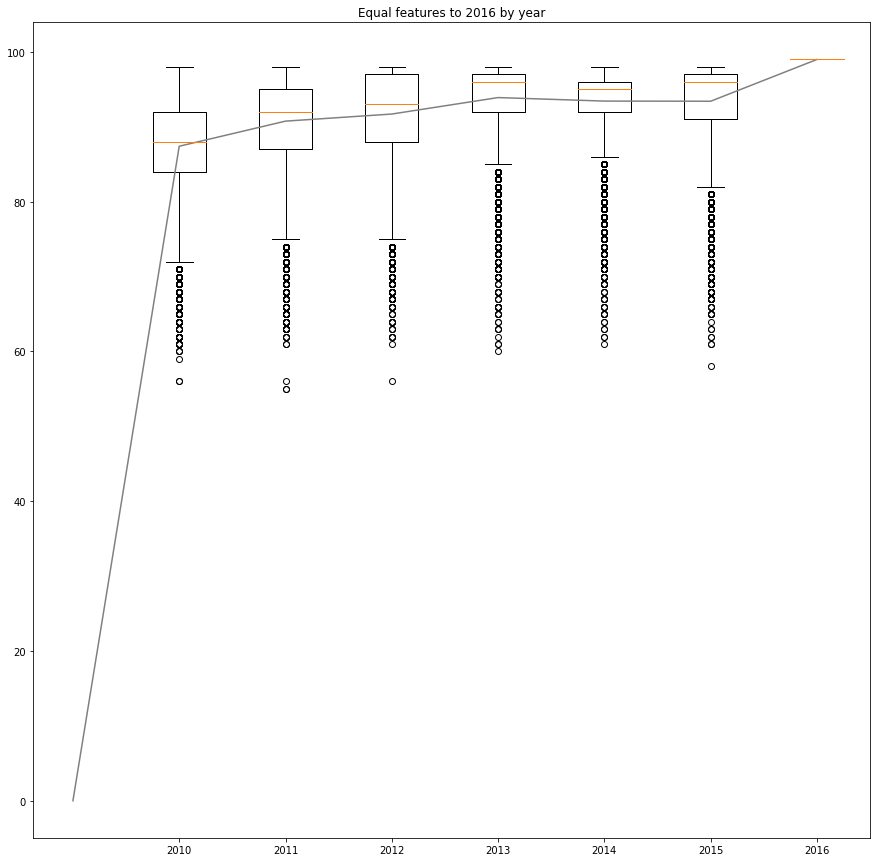

In [3]:
# CELL 3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not DO_EDA:
    display(Image(filename=os.path.join("..", "media", "cell3.png")))
else:
    city_col = 0
    to_plot = list()
    means = list()
    city_to_data = None
    deleted_cities = set()
    for version in range(7):
        datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
        if version == 6:
            datafile = "ch6_cell32_dev_feat_conservative.tsv"
        this_city_data = dict()
        with open(datafile) as f:
            next(f) # drop header
            for line in f:
                fields = line.split("\t")
                this_city_data[fields[city_col]] = list(map(float,fields[1:]))
        if city_to_data is None:
            city_to_data = dict()
            for city, data in this_city_data.items():
                city_to_data[city] = [ data ]
        else:
            to_delete = list()
            for city, l in city_to_data.items():
                if city in this_city_data:
                    l.append(this_city_data[city])
                else:
                    deleted_cities.add(city)
                    to_delete.append(city)
            for city in to_delete:
                del city_to_data[city]
    print("Plotting on {:,}".format(len(city_to_data)))
    cities = sorted(list(city_to_data.keys()))
    for version in range(7):
        equal_counts = list()
        for city in cities:
            equal_count = 0
            for idx in range(len(city_to_data[city][-1])):
                if city_to_data[city][version][idx] == city_to_data[city][-1][idx]:
                    equal_count += 1
            equal_counts.append(equal_count)
        equal_counts = np.array(equal_counts)
        to_plot.append(equal_counts)
        means.append(np.mean(equal_counts))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title('Equal features to 2016 by year')
    ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
    means.insert(0,0)
    ax.plot(range(8), means, 'b-', color='gray')
    plt.savefig("ch7_cell3_boxplot.pdf", bbox_inches='tight', dpi=300)
    plt

The trend is similar to the one observed in the rel count alone. This data seems reasonable for trying lagged features but temporal smoothing using a sliding window might provide better results given the bouncy behaviour of the data.

To conclude the EDA, let us take a look at the behaviour of the difference between the target variable, population 
(Cell #4).

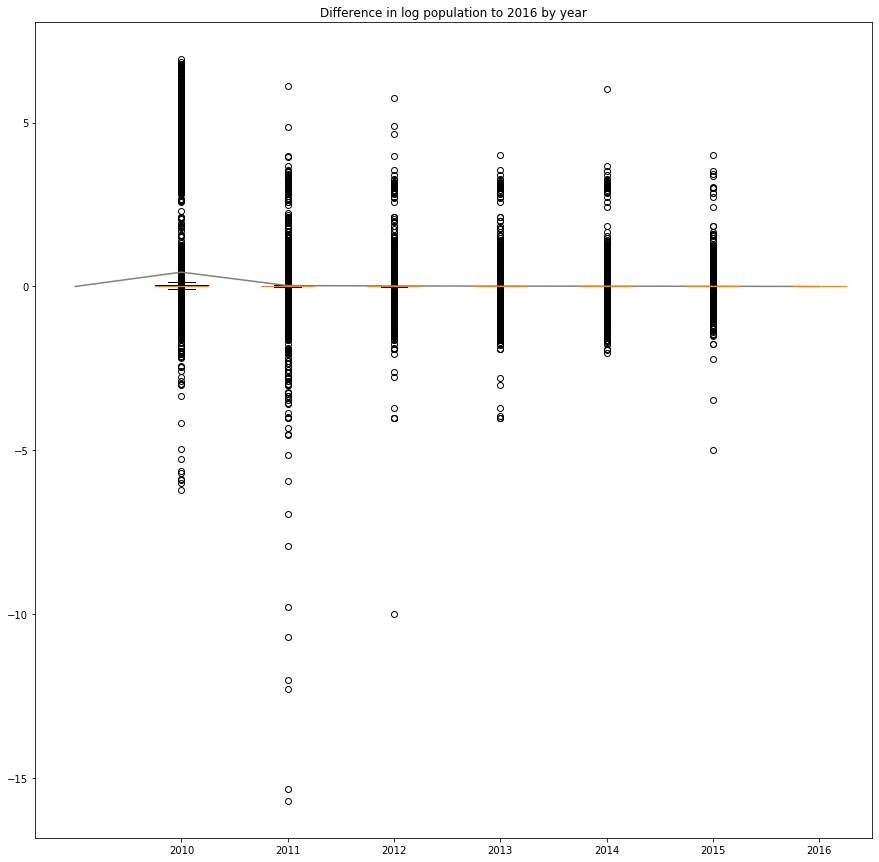

In [4]:
# CELL 4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not DO_EDA:
        display(Image(filename=os.path.join("..", "media", "cell4.png")))
else:
    city_col = 0
    pop_col = 99
    to_plot = list()
    means = list()
    city_to_data = None
    deleted_cities = set()
    for version in range(7):
        datafile = "dbpedia1" + str(version) + "_dev_conservative.tsv"
        if version == 6:
            datafile = "ch6_cell32_dev_feat_conservative.tsv"
        city_pop  = dict()
        with open(datafile) as f:
            first = True
            for line in f:
                fields = line.strip().split("\t")
                if first:
                    first = False
                    if fields[city_col] != 'name':
                        raise Exception("Expected 'name', got " + fields[city_col])
                    if fields[pop_col] != 'population':
                        raise Exception("Expected 'population', got " + fields[pop_col])
                else:
                    city_pop[fields[city_col]] = float(fields[pop_col])
        if city_to_data is None:
            city_to_data = dict()
            for city, rel in city_pop.items():
                city_to_data[city] = [ rel ]
        else:
            to_delete = list()
            for city, l in city_to_data.items():
                if city in city_pop and city_pop[city] > 0:
                    l.append(city_pop[city])
                else:
                    deleted_cities.add(city)
                    to_delete.append(city)
            for city in to_delete:
                del city_to_data[city]
    print("Plotting on {:,}".format(len(city_to_data)))
    cities = sorted(list(city_to_data.keys()))
    for version in range(7):
        pops = np.array([ city_to_data[city][-1] - city_to_data[city][version] for city in cities])
        nonzero = np.count_nonzero(pops)
        print("Year {}, different: {:,} ({:%})".format(2010+version, nonzero, nonzero / len(pops)))
        to_plot.append(pops)
        means.append(np.mean(pops))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title('Difference in log population to 2016 by year')
    ax.boxplot(to_plot, labels=list(range(2010,2017)), meanline=True)
    means.insert(0,0)
    ax.plot(range(8), means, 'b-', color='gray')
    plt.savefig("ch7_cell4_boxplot.pdf", bbox_inches='tight', dpi=300)
    plt

Interestingly, the population numbers have changed since 2010 until 2016, even though census happen in different countries once every ten years. Also, restricting to the cities with known population for all the years does not show any bump in 2015 as in the other years. Initially, I would have expected the target population will be so accurate that giving it to the ML will constitute a target leak. While the actual number might not be the exact number,  the box plot shows the number is on average the same, with some marked outliers.

Let's try to study the missing values now.

### Missing values

There are two sources for needs of missing values:

1. Empty relation for that year (the whole column will be empty)
1. Missing city for that year (the whole row will be empty)

I will detect these two cases, making an indicator feature for each cell based on these two sources and saving them for further imputation (Cell #5).

In [5]:
# CELL 5
import random
import math
import numpy as np

rand = random.Random(42)

if not DO_EDA:
    print("""Total empty cols 186
Empty cols for 2010: 37
Empty cols for 2011: 29
Empty cols for 2012: 29
Empty cols for 2013: 29
Empty cols for 2014: 62
Empty cols for 2015: 0
Working on 44,959 cities
Total empty rows 37,144
Empty rows for 2010: 9990
Empty rows for 2011: 8147
Empty rows for 2012: 6808
Empty rows for 2013: 2160
Empty rows for 2014: 1538
Empty rows for 2015: 8501
Total cells: 26,705,646 missing: 11,078,309 (41.483022%)
""")
else:
    # get data sizes
    VERSIONS=6 # + 1 for current

    with open("ch6_cell32_dev_feat_conservative.tsv") as f:
        FEATS = len(next(f).split('\t')) - 1 # name
        CITIES = 0
        for _ in f:
            CITIES += 1

    # load data
    CITY_COL = 0
    header_line = None
    city_names = dict() # name to idx

    table = np.zeros( (CITIES, FEATS * 2 * VERSIONS + FEATS) )

    with open("ch6_cell32_dev_feat_conservative.tsv") as f:
        header_line = next(f)
        city_idx = 0
        for line in f:
            fields = line.strip().split("\t")
            floats = list(map(float,fields[1:]))
            for idx, val in enumerate(floats):
                if math.isnan(val):
                    floats[idx] = 0.0
            table[city_idx,-FEATS:] = floats
            city_names[fields[CITY_COL]] = city_idx
            city_idx += 1
    header = header_line.strip().split("\t")

    year_defined = { city: set() for city in city_names }
    for version in range(VERSIONS):
        with open("dbpedia1" + str(version) + "_dev_conservative.tsv") as f:
            header_line = next(f)
            for line in f:
                fields = line.strip().split("\t")
                city = fields[CITY_COL]
                city_idx = city_names.get(city, None)
                if city_idx is None:
                    continue
                year_defined[city].add(version)
                floats = list(map(float,fields[1:]))
                for idx, val in enumerate(floats):
                    table[city_idx,FEATS * 2 * version + 2 * idx] = 1.0 # defined
                    if math.isnan(val):
                        table[city_idx,FEATS * 2 * version + 2 * idx + 1] = 0.0
                    else:
                        table[city_idx,FEATS * 2 * version + 2 * idx + 1] = val

    # column-based missing values: determine empty/constant columns
    empty_cols_per_year = list()
    for version in range(VERSIONS):
        empty_cols = 0
        for col in range(FEATS):
            value = None
            constant = True
            for city_idx in range(CITIES):
                this_val = table[city_idx, 2 * version * FEATS + 2 * col + 1]
                if value is None:
                    value = this_val
                elif value != this_val:
                    constant = False
                    break
            if constant:
                empty_cols += 1
                table[:, 2 * version * FEATS + 2 * col] = 0.0 # missing
        empty_cols_per_year.append(empty_cols)
    print("Total empty cols {:,}".format(sum(empty_cols_per_year)))
    for version in range(6):
        print("Empty cols for {}: {}".format(2010+version, empty_cols_per_year[version]))
    print("Working on {:,} cities".format(CITIES))

    # row-based imputation: determine empty years
    empty_rows_per_year = list()
    for version in range(6):
        empty_rows = 0
        for city, city_idx in city_names.items():
            if version not in year_defined[city] or \
            all(map(lambda x:table[city_idx, 2*version * FEATS + 2 * x + 1] == 0.0, range(FEATS))):
                empty_rows += 1
                for col in range(FEATS):
                    table[city_idx, 2 * version * FEATS + 2 * col] = 0.0
        empty_rows_per_year.append(empty_rows)
    print("Total empty rows {:,}".format(sum(empty_rows_per_year)))
    for version in range(6):
        print("Empty rows for {}: {}".format(2010+version, empty_rows_per_year[version]))

    # write feature table
    missing_cells = 0
    total_cells = 0
    with open("ch7_cell5_dev_missing.tsv", "w") as w:
        w.write('name')
        for version in range(VERSIONS):
            for featname in header[1:]:
                w.write("\t{}_{}?is_defined".format(2010+version, featname))
                w.write("\t{}_{}".format(2010+version, featname))
        w.write('\t' + '\t'.join(header[1:]) + "\n")
        for city, city_idx in city_names.items():
            w.write(city + "\t" + "\t".join(map(str, table[city_idx,:])) + "\n")
            total_cells += FEATS * VERSIONS
            for version in range(VERSIONS):
                for col in range(FEATS):
                    if table[city_idx, 2 * version * FEATS + 2 * col] == 0.0:
                        missing_cells += 1
    print("Total cells: {:,} missing: {:,} ({:%})".format(total_cells, missing_cells, missing_cells / total_cells))

Total empty cols 186
Empty cols for 2010: 37
Empty cols for 2011: 29
Empty cols for 2012: 29
Empty cols for 2013: 29
Empty cols for 2014: 62
Empty cols for 2015: 0
Working on 44,959 cities
Total empty rows 37,144
Empty rows for 2010: 9990
Empty rows for 2011: 8147
Empty rows for 2012: 6808
Empty rows for 2013: 2160
Empty rows for 2014: 1538
Empty rows for 2015: 8501
Total cells: 26,705,646 missing: 11,078,309 (41.483022%)



There is a significant amount of missing values. Let us see if we can visualize now individual entries. For visualization, I'll use a heatmap, discretizing features into up to six bins using k-means clustering. The top three clusters will be shown in green, the bottom in blue. Missing values will be shown in red.

The graph aligns features for each year to follow them, uncovering the story of the data (Cell #6).

Mérida,_Yucatán: 5.986 (970,376 people)


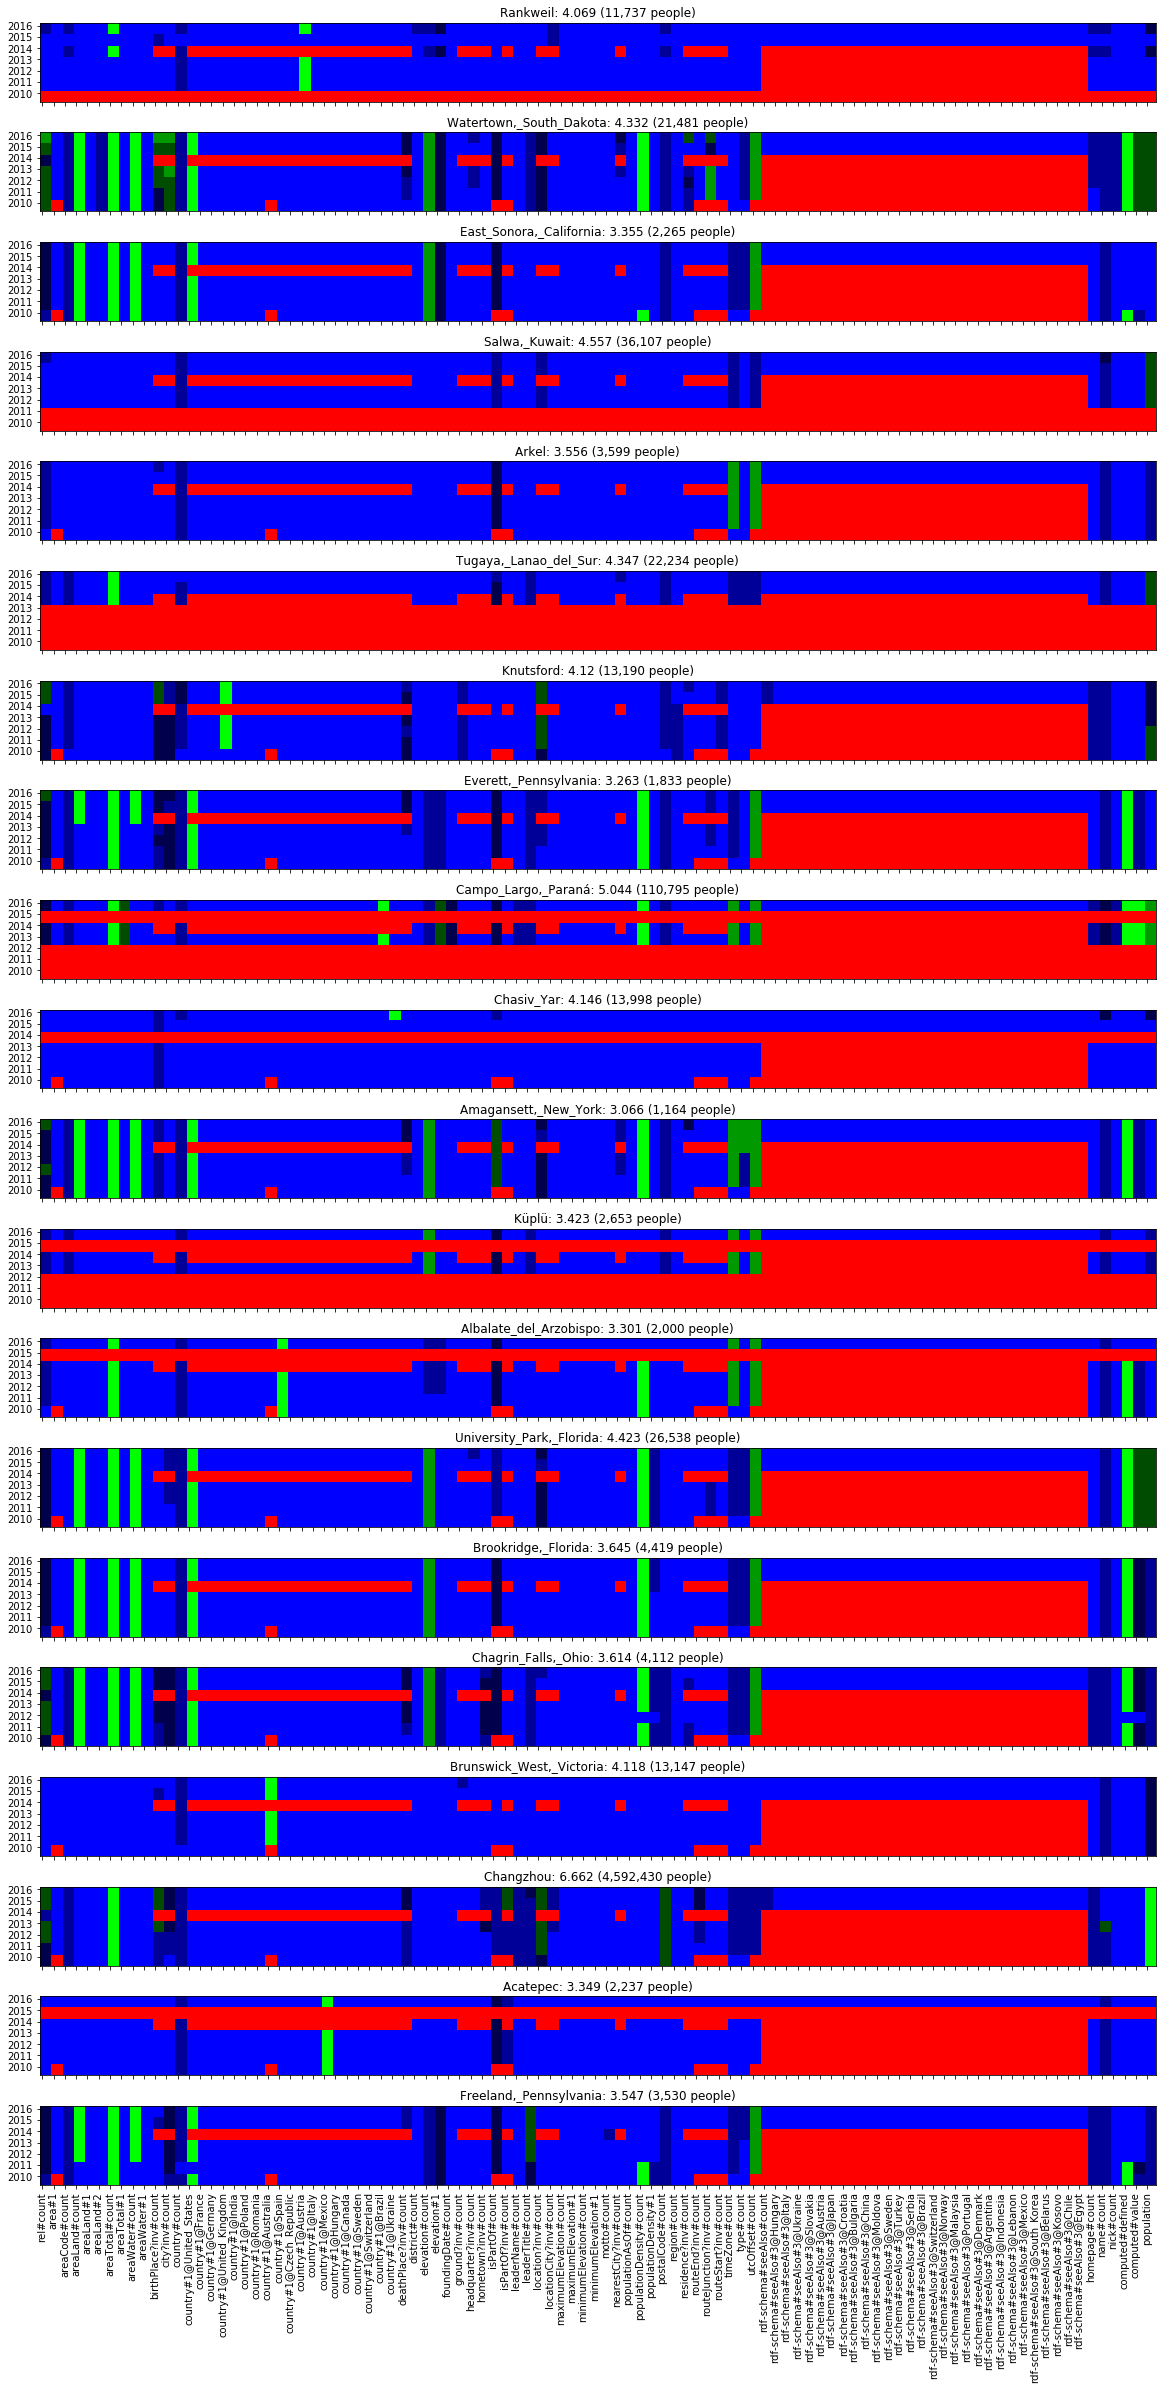

In [6]:
# CELL 6
import random
import math
import numpy as np
import gzip
from sklearn.cluster import KMeans

rand = random.Random(42)

header = None
data = list()
with gzip.open(os.path.join("..", "data", "ch7_cell5_dev_missing.tsv.gz"), "rt") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# compute boundaries using kMeans
boundaries = list()
for feat in range(FEATS):
    col = table[:,2*VERSIONS*FEATS + feat]
    vals = set(col)
    num_clusters = min(len(vals), 6)
    if num_clusters < 6:
        boundaries.append(sorted(vals))
    else:
        kmeans = KMeans(n_clusters=6, random_state=1).fit(col.reshape(-1,1))
        boundaries.append(sorted(set(list(kmeans.cluster_centers_.reshape(-1)))))

# pick some cities at random to graph
to_show = rand.sample(list(range(len(data))), 20)

def colorize(feat, feat_val):
    num_classes = len(boundaries[feat])
    half_classes = num_classes // 2
    if half_classes == 0:
        half_classes = 1
    dists = sorted(map(lambda x: (abs(x[1]-feat_val), x[0]), enumerate(boundaries[feat])))
    clazz = dists[0][1]
    if clazz >= half_classes:
        component = 1
        clazz -= half_classes
    else:
        component = 2
        clazz = half_classes - clazz - 1
        
    intensity = None
    if clazz == 0:
        if half_classes == 3:
            intensity = 0.3
        elif half_classes == 2:
            intensity = 0.6
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 1:
        if half_classes == 3:
            intensity = 0.6
        elif half_classes == 2:
            intensity = 1.0
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 2:
        intensity = 1.0
    box_color = [ 0.0, 0.0, 0.0 ]
    box_color[component] = intensity
    #print(dists, clazz, num_classes, half_classes, box_color)
    return box_color

def gray(box_color):
    if box_color[0] == 1.0:
        col = 0.0
    elif box_color[1] == 0.0:
        col = box_color[2] / 2
    else:
        col = 0.5 + box_color[1] / 2
    return [ col, col, col ]

HEIGHT=2
WIDTH=2

def shrink_name(feat_name):
    if '@' in feat_name:
        parts = feat_name.split('@')
        return parts[0].split("/")[-1] + "@" + parts[1].split("/")[-1][:-1]
    else:
        if '/' in feat_name:
            return feat_name.split("/")[-1]
    return feat_name

img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
img[:,:,:] = 1.0

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

plt.axis('on')
yticks_locs = list(map(lambda x:x*HEIGHT, range(VERSIONS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(VERSIONS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:shrink_name(x), base_features))
plt.yticks(yticks_locs, yticks_labels)
plt.xticks(xticks_locs, xticks_labels, rotation=90)

idx = list(filter(lambda x:x[1][-1].endswith("Mérida,_Yucatán>"), enumerate(data)))[0][0]
xbox = 0
for feat in range(FEATS):
    ybox = feat * WIDTH
    img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = gray(colorize(feat, 
                                                                      table[idx, 2 * VERSIONS * FEATS + feat]))
for version in range(VERSIONS):
    xbox = (VERSIONS - version) * HEIGHT
    for feat in range(FEATS):
        ybox = feat * WIDTH
        box_color = gray(colorize(feat, table[idx, 2 * version * FEATS + 2 * feat + 1]))
        # mark imputation
        if table[idx,  2 * FEATS * version + 2 * feat] == 0.0:
            img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = [ 1.0, 1.0, 1.0 ]
            img[ xbox + 1, ybox ] = [ 0.0, 0.0, 0.0 ]
            img[ xbox, ybox + 1 ] = [ 0.0, 0.0, 0.0 ]
        else:
            img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
print("{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                               int(data[idx][1]*1000)/1000.0,
                                               int(10**data[idx][1])))
plt.imshow(img, aspect='equal')
plt.savefig(os.path.join("..","media","cell6_viz.pdf"), bbox_inches='tight', dpi=300)


from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

plt.axis('on')
for img_idx, idx in enumerate(to_show):
    plt.subplot(len(to_show), 1, img_idx + 1)
    plt.title("{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                               int(data[idx][1]*1000)/1000.0,
                                               int(10**data[idx][1])))
    img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
    img[:,:,:] = 1.0

    xbox = 0
    for feat in range(FEATS):
        ybox = feat * WIDTH
        img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = colorize(feat, 
                                                                     table[idx, 2 * VERSIONS * FEATS + feat]) 
    for version in range(VERSIONS):
        xbox = (VERSIONS - version) * HEIGHT
        for feat in range(FEATS):
            ybox = feat * WIDTH
            box_color = colorize(feat, table[idx, 2 * version * FEATS + 2 * feat + 1])
            # mark imputation
            if table[idx,  2 * FEATS * version + 2 * feat] == 0.0:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = [1.0, 0, 0 ]
            else:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
    plt.imshow(img, aspect='equal')
    plt.yticks(yticks_locs, yticks_labels)
    plt.xticks(xticks_locs, [] if img_idx < len(to_show) - 1 else xticks_labels, rotation=90)
plt.savefig(os.path.join("..","media","cell6_viz_full.pdf"), bbox_inches='tight', dpi=300)

From the figure we can see that the relation counts change from version to version but the target population seem to stay within the same range. There are plenty of missing features and the colours indicate a relative growth over time.

The "seeAlso" features are missing for all years, that's a big loss.

## First featurization: time lagged features

Given the large percentage of cities that are not present in all years, we will need a way to impute them.

### Imputation

I will use the closer available year, given priority to earlier years (Cell #7).

In [8]:
# CELL 7
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
# load data
with gzip.open(os.path.join("..","data","ch7_cell5_dev_missing.tsv.gz"), "rt") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]
    
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# impute
back_imputed = 0
forward_imputed = 0
present_imputed = 0
for city_idx in range(CITIES):
    for version in range(VERSIONS):
        for feat in range(FEATS):
            if table[city_idx,  2 * FEATS * version + 2 * feat] == 1.0:
                continue
            lag = 1
            imputed = False
            while version + lag <= VERSIONS or version - lag >= 0:
                if version - lag >= 0 and table[city_idx,  2 * FEATS * (version - lag) + 2 * feat] == 1.0:
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version - lag) + 2 * feat + 1]
                    back_imputed += 1
                    imputed = True
                    break
                if version + lag < VERSIONS and table[city_idx,  2 * FEATS * (version + lag) + 2 * feat] == 1.0:
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version + lag) + 2 * feat + 1]
                    forward_imputed += 1
                    imputed = True
                    break
                if version + lag == VERSIONS: # present
                    table[city_idx,  2 * FEATS * version + 2 * feat + 1] = \
                      table[city_idx,  2 * FEATS * (version + lag) + feat]
                    present_imputed += 1
                    imputed = True
                    break
                lag += 1
            if not imputed:
                print(version, feat, data[city_idx][-1])

# write full feature table
imputed_cells = 0
total_cells = 0
with open(os.path.join("..","data", "cell7_dev_imputed.tsv"), "w") as w:
    w.write('name')
    w.write('\t' + '\t'.join(header) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        total_cells += FEATS * VERSIONS
        w.write(city)
        w.write('\t' + '\t'.join(map(str, table[city_idx,:])))
        w.write('\n')
imputed_cells = back_imputed + forward_imputed + present_imputed
print("Total cells: {:,} imputed: {:,} ({:%})".format(total_cells, imputed_cells, imputed_cells / total_cells))
print("Backward imputed: {:,} ({:%})".format(back_imputed, back_imputed / imputed_cells))
print("Forward imputed: {:,} ({:%})".format(forward_imputed, forward_imputed / imputed_cells))
print("Present imputed: {:,} ({:%})".format(present_imputed, present_imputed / imputed_cells))

Total cells: 26,705,646 imputed: 11,078,309 (41.483022%)
Backward imputed: 1,770,176 (15.978756%)
Forward imputed: 7,154,111 (64.577644%)
Present imputed: 2,154,022 (19.443599%)


So most features are not present-imputed. That is important because otherwise there will be little value of the historical features. 

Let us visualize this (Cell #8).

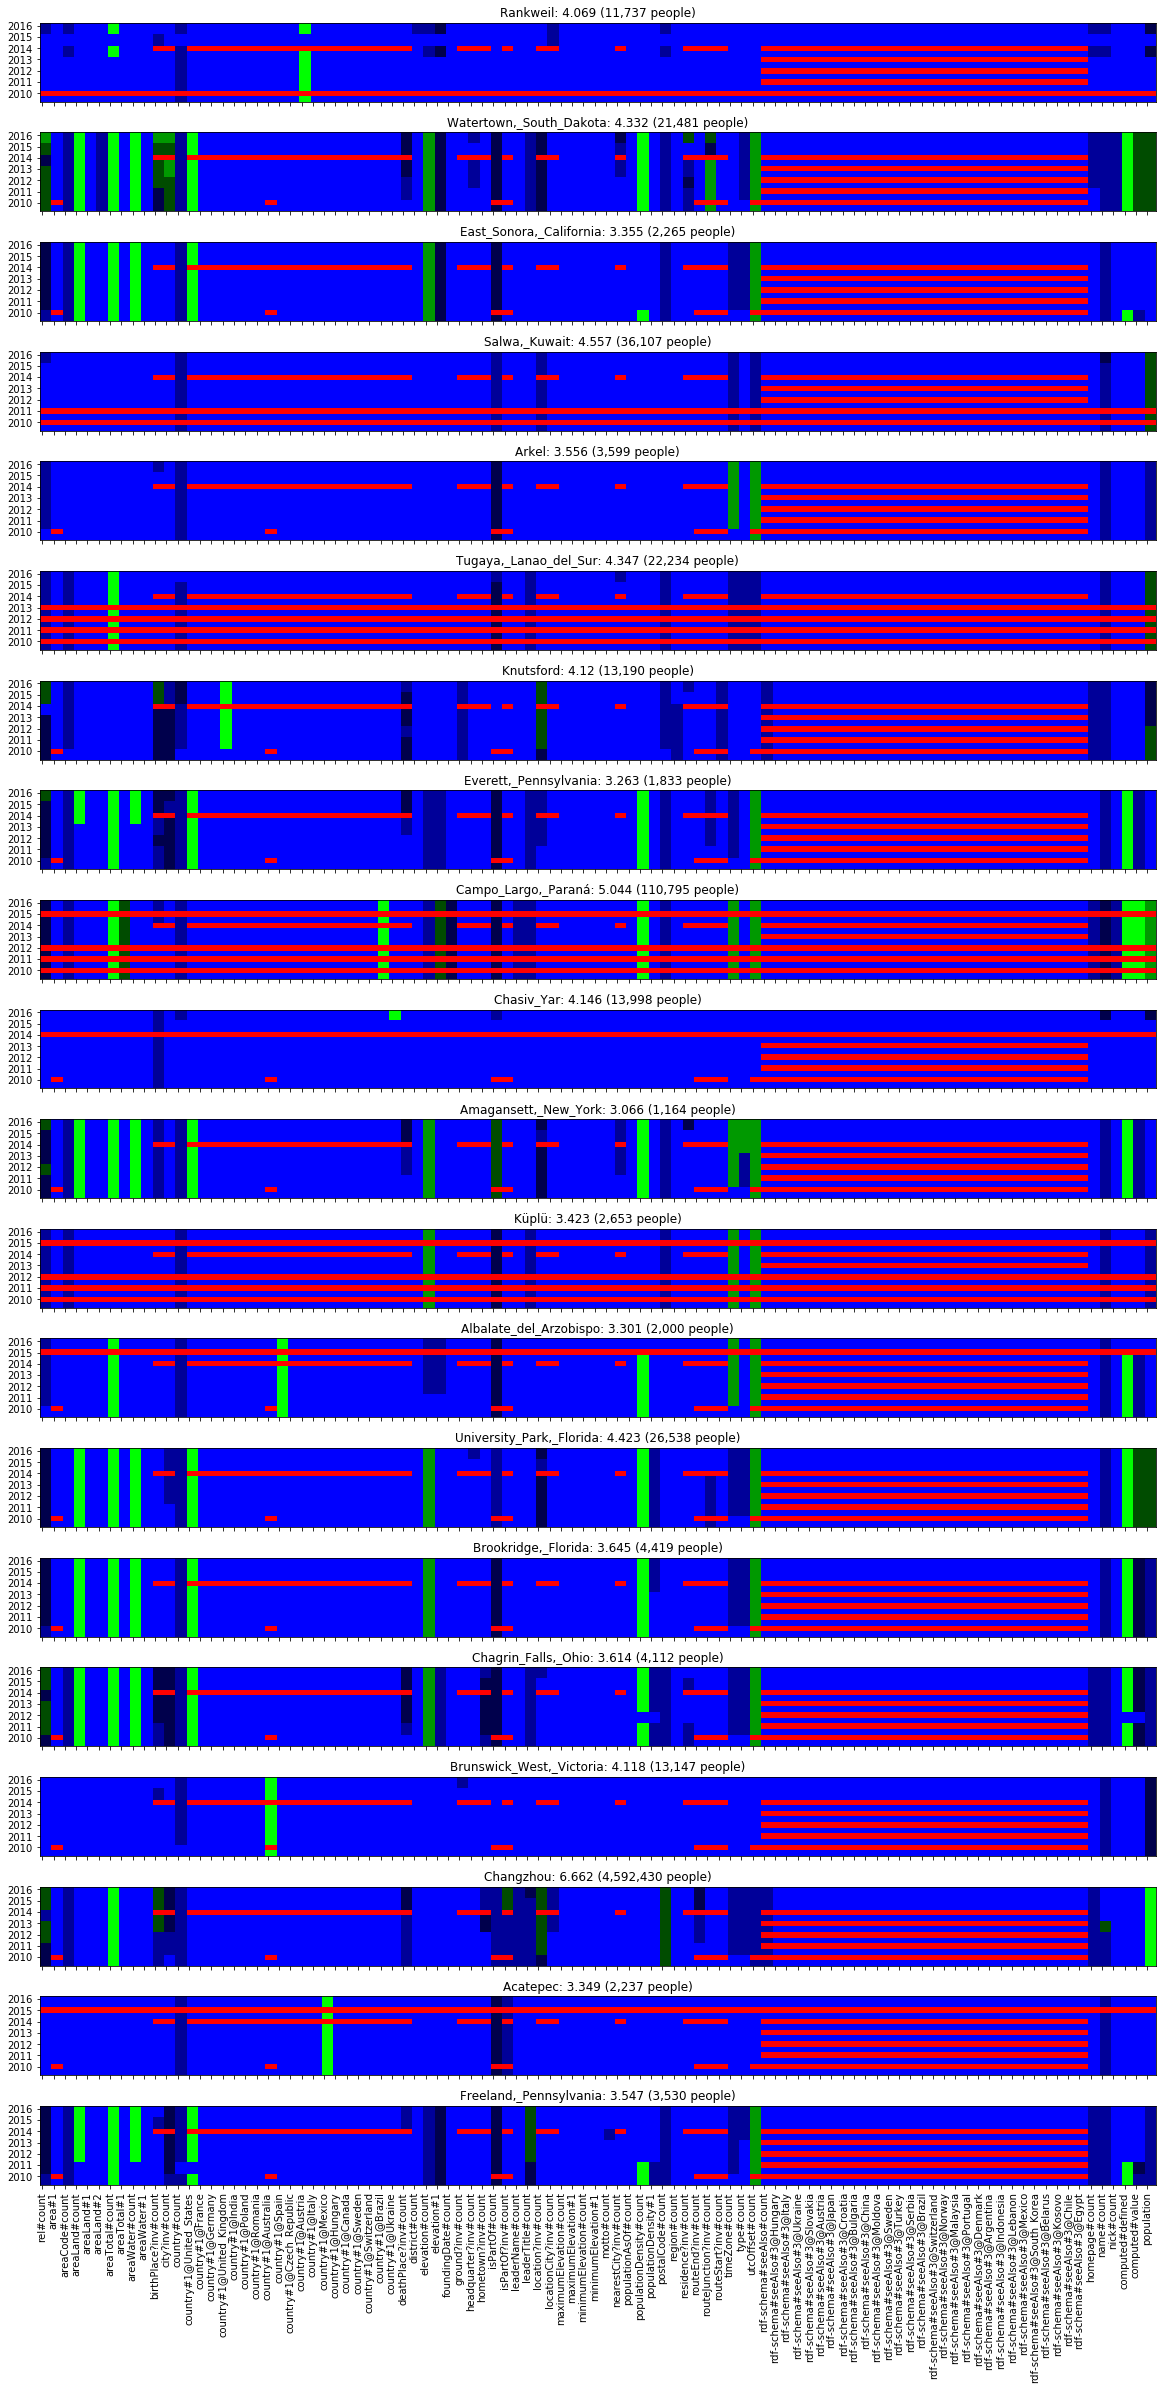

In [10]:
# CELL 8
import random
import math
import numpy as np
from sklearn.cluster import KMeans

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..", "data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# compute boundaries using kMeans
boundaries = list()
for feat in range(FEATS):
    col = table[:,2*VERSIONS*FEATS + feat]
    vals = set(col)
    num_clusters = min(len(vals), 6)
    if num_clusters < 6:
        boundaries.append(sorted(vals))
    else:
        kmeans = KMeans(n_clusters=6, random_state=1).fit(col.reshape(-1,1))
        boundaries.append(sorted(set(list(kmeans.cluster_centers_.reshape(-1)))))
        
# save boundaries
with open(os.path.join("..", "data", "cell8_boundaries.tsv"), "w") as b:
    for idx, boundary_list in enumerate(boundaries):
        b.write("{}\t{}\n".format(idx, "\t".join(map(str,boundary_list))))

# pick some cities at random to graph
to_show = rand.sample(list(range(len(data))), 20)

def cell8_colorize(feat, feat_val, boundaries):
    num_classes = len(boundaries[feat])
    half_classes = num_classes // 2
    if half_classes == 0:
        half_classes = 1
    dists = sorted(map(lambda x: (abs(x[1]-feat_val), x[0]), enumerate(boundaries[feat])))
    clazz = dists[0][1]
    if clazz >= half_classes:
        component = 1
        clazz -= half_classes
    else:
        component = 2
        clazz = half_classes - clazz - 1
        
    intensity = None
    if clazz == 0:
        if half_classes == 3:
            intensity = 0.3
        elif half_classes == 2:
            intensity = 0.6
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 1:
        if half_classes == 3:
            intensity = 0.6
        elif half_classes == 2:
            intensity = 1.0
        elif half_classes == 1:
            intensity = 1.0
    elif clazz == 2:
        intensity = 1.0
    box_color = [ 0.0, 0.0, 0.0 ]
    box_color[component] = intensity
    #print(dists, clazz, num_classes, half_classes, box_color)
    return box_color

HEIGHT=2
WIDTH=2

def cell8_shrink_name(feat_name):
    if '@' in feat_name:
        parts = feat_name.split('@')
        return parts[0].split("/")[-1] + "@" + parts[1].split("/")[-1][:-1]
    else:
        if '/' in feat_name:
            return feat_name.split("/")[-1]
    return feat_name

img = np.zeros( [ (VERSIONS + 1) * HEIGHT, FEATS * WIDTH, 3 ])
img[:,:,:] = 1.0


yticks_locs = list(map(lambda x:x*HEIGHT, range(VERSIONS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(VERSIONS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:cell8_shrink_name(x), base_features))

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]

def cell8_draw_features(plot, row, title, versions, boundaries,
                        yticks_locs, yticks_labels, xticks_locs, xticks_labels):
    if title is not None:
        plot.title(title)
    img = np.zeros( [ (versions + 1) * HEIGHT, FEATS * WIDTH, 3 ])
    img[:,:,:] = 1.0

    xbox = 0
    for feat in range(FEATS):
        ybox = feat * WIDTH
        img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = \
           cell8_colorize(feat, row[2 * versions * FEATS + feat], boundaries) 
    for version in range(versions):
        xbox = (versions - version) * HEIGHT
        for feat in range(FEATS):
            ybox = feat * WIDTH
            box_color = cell8_colorize(feat, row[2 * version * FEATS + 2 * feat + 1], boundaries)
            # mark imputation
            if row[2 * FEATS * version + 2 * feat] == 0.0:
                img[ xbox:(xbox + HEIGHT // 2), ybox: (ybox + WIDTH) ] = [1.0, 0, 0 ]
                img[ (xbox + HEIGHT // 2):(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color
            else:
                img[ xbox:(xbox + HEIGHT), ybox: (ybox + WIDTH) ] = box_color 
    plot.imshow(img, aspect='equal')
    plot.yticks(yticks_locs, yticks_labels)
    plot.xticks(xticks_locs, xticks_labels, rotation=90)    

plt.axis('on')
for img_idx, idx in enumerate(to_show):
    plt.subplot(len(to_show), 1, img_idx + 1)
    cell8_draw_features(plt, table[idx,:], "{}: {} ({:,} people)".format(data[idx][-1].split("/")[-1][:-1],
                                            int(table[idx,-1]*1000)/1000.0,
                                            int(10**table[idx,-1])), 
                        VERSIONS, boundaries, 
                        yticks_locs, yticks_labels, xticks_locs, 
                        [] if img_idx < len(to_show) - 1 else xticks_labels)

plt.savefig(os.path.join("..","media","cell8_viz_full.pdf"), bbox_inches='tight', dpi=300)

The imputation looks like it completes quite well the values. Watertown seems to have some surprises in the center. We are now ready for the first featurization.

For the first featurization, I will add the historical version of each feature, for the last two versions (Cell #9). Due to the large number of features, I will switch to RFs.

/home/pablo/local/virtualenv/feateng/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Features: 490
Training on 35,971 cities
RMSE 0.35399610085652156
Writing files for error analysis


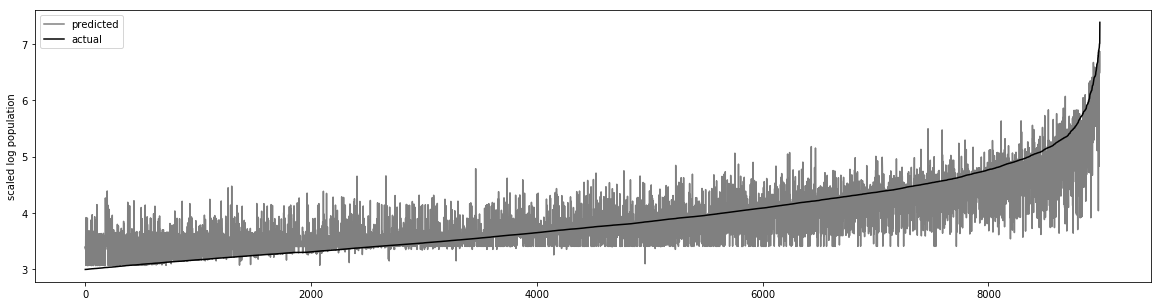

In [12]:
# CELL 9
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..","data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)
        
# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open(os.path.join("..", "data", "cell9_dev_feat1.tsv"), "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed(os.path.join("..", "data", "cell9_feat1_rf.npz"), 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open(os.path.join("..", "data", "cell9_model.pk"), "wb") as pkl:
    pickle.dump(rfr, pkl)
with open(os.path.join("..", "data", "cell9_test_names.tsv"), "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell9_rf_feat1.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

So this does barely improves over the SVR baseline (0.3578). Let us see the RMSE for using other lags in Cell #10.

In [13]:
# CELL 10
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

header = None
data = list()
with open(os.path.join("..", "data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

for lag in range(0, VERSIONS):
    train_data = list()
    test_data = list()
    
    rand = random.Random(42)
    for full_row in data:
        feats = list()
        for l in range(lag):
            feats.extend(full_row[0][2*(VERSIONS-l-1)*FEATS: 2*(VERSIONS-l)*FEATS])
        feats.extend(full_row[0][2*VERSIONS*FEATS:])
        row = (feats, full_row[1], full_row[-1])
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
    test_data = sorted(test_data, key=lambda t:t[1])
    test_names = list(map(lambda t:t[2], test_data))

    xtrain = np.array(list(map(lambda t:t[0], train_data)))
    ytrain = np.array(list(map(lambda t:t[1], train_data)))
    xtest = np.array(list(map(lambda t:t[0], test_data)))
    ytest = np.array(list(map(lambda t:t[1], test_data)))

    # train
    rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
    rfr.fit(xtrain, ytrain)
    ytest_pred = rfr.predict(xtest)
    RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
    print("Lag: {}, Features: {:4d}, RMSE RF: {}".format(lag, FEATS * lag * 2 + FEATS, RMSE))
    rfr=None # free memory

Lag: 0, Features:   98, RMSE RF: 0.3594471409427478
Lag: 1, Features:  294, RMSE RF: 0.3551285335405209
Lag: 2, Features:  490, RMSE RF: 0.35399610085652156
Lag: 3, Features:  686, RMSE RF: 0.3539181813586395
Lag: 4, Features:  882, RMSE RF: 0.35426716669977154
Lag: 5, Features: 1078, RMSE RF: 0.35400022440553247


Before doing Error Analysis, let's look at computing differences (Cell #11).

In [14]:
# CELL 11
import random
import math
from sklearn.ensemble import RandomForestRegressor
import numpy as np

header = None
data = list()
with open(os.path.join("..", "data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

for lag in range(0, VERSIONS):
    train_data = list()
    test_data = list()
    
    rand = random.Random(42)
    for full_row in data:
        feats = list()
        for l in range(lag):
            for feat in range(FEATS):
                feats.append(full_row[0][2*VERSIONS*FEATS+feat] - full_row[0][2*(VERSIONS-l-1)*FEATS+2*feat+1])
        feats.extend(full_row[0][2*VERSIONS*FEATS:])
        row = (feats, full_row[1], full_row[-1])
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
    test_data = sorted(test_data, key=lambda t:t[1])
    test_names = list(map(lambda t:t[2], test_data))

    xtrain = np.array(list(map(lambda t:t[0], train_data)))
    ytrain = np.array(list(map(lambda t:t[1], train_data)))
    xtest = np.array(list(map(lambda t:t[0], test_data)))
    ytest = np.array(list(map(lambda t:t[1], test_data)))

    # train
    rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
    rfr.fit(xtrain, ytrain)
    ytest_pred = rfr.predict(xtest)
    RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
    print("Lag: {}, Features: {:4d}, RMSE RF: {}".format(lag, FEATS * lag * 2 + FEATS, RMSE))
    rfr=None # free memory

Lag: 0, Features:   98, RMSE RF: 0.3594471409427479
Lag: 1, Features:  294, RMSE RF: 0.3599426696315793
Lag: 2, Features:  490, RMSE RF: 0.35881075378336114
Lag: 3, Features:  686, RMSE RF: 0.35887561711200916
Lag: 4, Features:  882, RMSE RF: 0.3584098636378323
Lag: 5, Features: 1078, RMSE RF: 0.35837472455321523


The absolute differences might be a problem and scaling the differences will not work either as many features are zero. Let us drill down.


## Error Analysis

I'll use the feature heatmaps to see which cities did worse with the lags than without them (Cell #12).

In [ ]:
# CELL 12
import random
import math
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# load
arrays = np.load(os.path.join("..", "data", "cell9_feat1_rf.npz"))
xtrain = arrays['xtrain']
ytrain = arrays['ytrain']
xtest = arrays['xtest']
ytest = arrays['ytest']
ytest_pred = arrays['ytest_pred']

with open(os.path.join("..", "data", "cell9_dev_feat1.tsv")) as f:
    header = next(f).split('\t')
    del header[0] # name
    header.pop() # pop

base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
LAGS = 2

test_names = list()
with open(os.path.join("..", "data", "cell9_test_names.tsv")) as names:
    for line in names:
        test_names.append(line.split("\t")[-1])

# train on base features only
xtrain_base = xtrain[:,2*LAGS*FEATS:]
xtest_base = xtest[:,2*LAGS*FEATS:]
rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain_base, ytrain)
ytest_pred_base = rfr.predict(xtest_base)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
RMSE_base = math.sqrt(sum((ytest - ytest_pred_base)**2) / len(ytest))
print("RMSE lag 2: {}, RMSE base: {}".format(RMSE, RMSE_base))
rfr=None # free memory

# find 10 cities where it helped them most and 10 cities where it hurt the most
sqe_lag2 = (ytest - ytest_pred) ** 2
sqe_base = (ytest - ytest_pred_base) ** 2

diff = sqe_base - sqe_lag2
idx_diff = sorted(list(zip(diff, range(len(diff)))))
    
# visualize
boundaries = list()
with open(os.path.join("..", "data", "cell8_boundaries.tsv")) as b:
    for line in b:
        boundaries.append(list(map(float, line.split("\t")[1:])))

yticks_locs = list(map(lambda x:x*HEIGHT, range(LAGS+1))) 
yticks_labels = list(map(lambda x:2016-x, range(LAGS+1))) 
xticks_locs = list(map(lambda x:x*WIDTH, range(FEATS)))
xticks_labels = list(map(lambda x:cell8_shrink_name(x), base_features))

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 40]
plt.axis('on')
for idx in range(30):
    city_idx = idx_diff[idx][1]
    plt.subplot(40, 1, idx + 1)
    row = list(xtest[city_idx,:])
    row.append(ytest[city_idx])
    cell8_draw_features(plt, row, 
                        "WORSE> {}. Pop: {:,}, lag-2: {:,} base: {:,}"
                           .format(test_names[city_idx].strip().split("/")[-1][:-1],
                                   int(10**row[-1]), int(10**ytest_pred[city_idx]), 
                                   int(10**ytest_pred_base[city_idx])),
                        LAGS, boundaries, yticks_locs, yticks_labels, xticks_locs, [])
for idx in range(10):
    city_idx = idx_diff[len(idx_diff) - idx - 1][1]
    plt.subplot(40, 1, 30 + idx + 1)
    row = list(xtest[city_idx,:])
    row.append(ytest[city_idx])
    cell8_draw_features(plt, row, 
                        "BEST> {}. Pop: {:,}, lag-2: {:,} base: {:,}"
                           .format(test_names[city_idx].strip().split("/")[-1][:-1],
                                   int(10**row[-1]), int(10**ytest_pred[city_idx]), 
                                   int(10**ytest_pred_base[city_idx])),
                        LAGS, boundaries, yticks_locs, yticks_labels, xticks_locs, 
                        [] if idx < 9 else xticks_labels)

plt.savefig(os.path.join("..", "media", "cell12_viz_full.pdf"), bbox_inches='tight', dpi=300)

RMSE lag 2: 0.35399610085652156, RMSE base: 0.3594471409427478


From the error analysis, it seems regressions on the first column might be problem. Smoothing that behaviour could work. 

## Second Featurization

Let's start with a simple moving average (Cell #13).

In [ ]:
# CELL 13
import random
import math
import numpy as np
from sklearn.ensemble import RandomForestRegressor

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..", "data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]

# SMA
smoothing_square = 0
smoothed_cells = 0
for city_idx in range(CITIES):
    for feat in range(FEATS):
        sma = 0
        for version in range(3):
            sma += table[city_idx,  2 * FEATS * version + 2 * feat + 1] / 3.0
        for version in range(3, VERSIONS + 1):
            diff = table[city_idx,  2 * FEATS * (version - 1) + 2 * feat + 1] - sma
            smoothed_cells += 1
            smoothing_square += diff * diff
            table[city_idx,  2 * FEATS * (version - 1) + 2 * feat + 1] = sma
            if version < VERSIONS:
                sma -= table[city_idx,  2 * FEATS * (version - 3) + 2 * feat + 1] / 3.0
                sma += table[city_idx,  2 * FEATS * version + 2 * feat + 1] / 3.0

# write full feature table
with open(os.path.join("..", "data", "cell13_dev_sma.tsv"), "w") as w:
    w.write('name\t' + '\t'.join(header[2*FEATS*2:]) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        w.write(city + '\t' + '\t'.join(map(str, table[city_idx,2*FEATS*2:])) + '\n')
        
print("Smoothed {:,} cells, root mean squared smoothing: {:,}".format(
   smoothed_cells, math.sqrt(smoothing_square/smoothed_cells)))

That's... a lot of smoothing. Now let's try again with lag-2 over the SMA for the second featurization (Cell #14).

In [ ]:
# CELL 14
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..", "data", "cell13_dev_sma.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 4
CITIES = len(data)
        
# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open(os.path.join("..", "data", "cell14_dev_feat2.tsv"), "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell14_rf_feat2.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

It got worse, which is not surprising given the level of smoothing. Let's try a different smoothing.

## Third Featurization

I will now use an exponential moving average from the present into the past, so I will combine smoothing with imputation (Cell #15).

In [ ]:
# CELL 15
import random
import math
import numpy as np

header = None
data = list()
# load data
with gzip.open(os.path.join("..", "data", "ch7_cell5_dev_missing.tsv.gz"), "rt") as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        feats = list(map(float, fields[1:]))
        data.append( (feats, feats[-1], name) )

table = np.zeros( (len(data), len(header)) )
for idx, row in enumerate(data):
    table[idx] = row[0]
    
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# impute and EMA
PARAM_EMA_WEIGHT = 0.2 # history is worth 80%, strong smoothing

smoothing_square = 0
smoothed_cells = 0
missed_imputed = 0
for city_idx in range(CITIES):
    for feat in range(FEATS):
        ema = table[city_idx,  2 * FEATS * VERSIONS + feat] 
        for upversion in range(VERSIONS):
            version = VERSIONS - upversion - 1
            smoothed = ema
            if table[city_idx,  2 * FEATS * version + 2 * feat] == 1.0:
                value = table[city_idx,  2 * FEATS * version + 2 * feat + 1]
                smoothed = PARAM_EMA_WEIGHT * value + (1.0 - PARAM_EMA_WEIGHT) * ema 
                smoothed_cells += 1
                diff = value - smoothed
                smoothing_square += diff * diff
            else:
                missed_imputed += 1
            table[city_idx,  2 * FEATS * version + 2 * feat + 1] = smoothed
            ema = smoothed

# write full feature table
imputed_cells = 0
total_cells = 0
with open(os.path.join("..", "data", "cell15_dev_ema_imputed.tsv"), "w") as w:
    w.write('name')
    w.write('\t' + '\t'.join(header) + "\n")
    for city_idx, city in enumerate(map(lambda x:x[-1], data)):
        w.write(city)
        w.write('\t' + '\t'.join(map(str, table[city_idx,:])))
        w.write('\n')
print("Total cells: {:,} missed imputed: {:,}".format(table.shape[0]*table.shape[1], missed_imputed))
print("Smoothed {:,} cells, root mean squared smoothing: {:,}".format(
   smoothed_cells, math.sqrt(smoothing_square/smoothed_cells)))

And now with a lag-2 RF (Cell #16).

In [ ]:
# CELL 16
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..", "data", "cell15_dev_ema_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

# assemble train/test for a given lag        
PARAM_LAG = 2

train_data = list()
test_data = list()

print("Features: {:,}".format(FEATS * PARAM_LAG * 2 + FEATS))
full_header = header
header = list()
for lag in range(PARAM_LAG):
    header.extend(full_header[2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
header.extend(full_header[2*VERSIONS*FEATS:])

for full_row in data:
    feats = list()
    for lag in range(PARAM_LAG):
        feats.extend(full_row[0][2*(VERSIONS-lag-1)*FEATS: 2*(VERSIONS-lag)*FEATS])
    feats.extend(full_row[0][2*VERSIONS*FEATS:])
    row = (feats, full_row[1], full_row[-1])
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)

# write feature set
with open(os.path.join("..", "data", "cell16_dev_feat3.tsv"), "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell16_rf_feat3.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

This improve a tiny bit, but it seems there is no value in the time dimension for this data set.

## Fourth Featurization

Finally, let's try using the extra rows as more training data (Cell #17).

In [ ]:
# CELL 17
import random
import math
import numpy as np

rand = random.Random(42)

header = None
data = list()
with open(os.path.join("..", "data", "cell7_dev_imputed.tsv")) as f:
    header = next(f).strip().split('\t')
    header.pop(0) # name
    pop_locs = list(reversed(list(map(lambda x:x[0],
                                      filter(lambda x:
                                             x[1].endswith("population") or
                                             x[1].endswith("population?is_defined"), enumerate(header))))))
    for del_loc in pop_locs:
        del header[del_loc]
    for line in f:
        fields = line.strip().split('\t')
        name = fields[0]
        pop = float(fields[-1])
        feats = list(map(float, fields[1:]))
        for del_loc in pop_locs:
            del feats[del_loc]
        data.append( (feats, pop, name) )
        
base_features=list(filter(lambda x: not x.startswith("201"), header))
FEATS = len(base_features)
VERSIONS = 6
CITIES = len(data)

full_train_data = list()
full_test_data = list()

print("Features: {:,}".format(FEATS))

# stratify
for row in data:
    if rand.random() < 0.2:
        full_test_data.append(row) 
    else:
        full_train_data.append(row)
        
train_data = list()
test_data = list()
for row in full_train_data:
    feats = row[0]
    # current
    train_data.append( (feats[2*FEATS*VERSIONS:], row[1], row[2]) )
    for version in range(VERSIONS):
        historical_feats = list()
        for feat in range(FEATS):
            if feats[2 * FEATS * version + 2 * feat] == 1.0:
                historical_feats.append(feats[2 * FEATS * version + 2 * feat + 1])
            else: # use current instead of imputed
                historical_feats.append(feats[2 * FEATS * VERSIONS + feat])
        # historical
        train_data.append( (historical_feats, row[1], row[2]) )

for row in full_test_data:
    # test only on current
    test_data.append( (row[0][2*FEATS*VERSIONS:], row[1], row[2]) )
    
# write feature set
with open(os.path.join("..", "data", "cell17_dev_feat4.tsv"), "w") as w:
    w.write('name\t' + '\t'.join(header) + '\tpopulation\n')
    all_data = list(train_data)
    all_data.extend(test_data)
    for row in all_data:
        w.write("{}\t{}\t{}\n".format(row[-1], '\t'.join(map(str, row[0])), row[1]))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# train
print("Training on {:,} cities".format(len(xtrain)))

rfr = RandomForestRegressor(max_features=1.0, random_state=42, max_depth=10, n_estimators=100, n_jobs=-1)
rfr.fit(xtrain, ytrain)
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)
rfr=None # free memory

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig(os.path.join("..", "media", "cell17_rf_feat4.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

That increased the available training material five-fold (from 35,000 to 25,000). However, things got much worse.

At this stage, I'll conclude the exercise, things left to try by the reader:

* Use the target population of the historical version instead of the current population
* Use an imputed version of the feature (e.g., the EMA version) instead of the current version
* Drop rows with too many imputed values
* Drop columns with too many imputed values

With the current experimental results I wouldn't advise to use the historical data for this task. If I am forced to pick a high performance feature set, it will be the imputed version using lag-5. A conservative feature set would be just adding the EMA-smoothing for historical relation counts (and nothing else).